# A/B тест на трёх вариантах

В данном исследовании предстоит определить, какой из трёх вариантов маркетинговой кампании для нового продукта фаст-фуд компании работает наиболее эффективно

## Подготовка данных

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [94]:
data = pd.read_csv('WA_Marketing-Campaign.csv')
data = data.drop_duplicates()
data = data.dropna()
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [95]:
data['MarketID'] = data['MarketID'].astype('category')
data['LocationID'] = data['LocationID'].astype('category')
data['Promotion'] = data['Promotion'] .astype('category')
data['week'] = data['week'] .astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MarketID          548 non-null    category
 1   MarketSize        548 non-null    object  
 2   LocationID        548 non-null    category
 3   AgeOfStore        548 non-null    int64   
 4   Promotion         548 non-null    category
 5   week              548 non-null    category
 6   SalesInThousands  548 non-null    float64 
dtypes: category(4), float64(1), int64(1), object(1)
memory usage: 21.5+ KB


## Проверка рандомизации распределения

Для корректного A/B теста нам необходимо проверить, что данные в трех группах (Promotion = 1, 2, 3) равномерно распределены по остальным двум признакам: MarketSize и AgeOfStore.

### Проведение тестов

In [96]:
age_summary = data.groupby('Promotion', observed=True)['AgeOfStore'].agg(['mean', 'std']).round(2)

ms_contingency = pd.crosstab(data['Promotion'], data['MarketSize'])

chi2, p_chi, dof, expected = stats.chi2_contingency(ms_contingency)
print(f"Chi-square test для MarketSize vs Promotion: chi2={chi2:.3f}, p-value={p_chi:.3f}")
if p_chi > 0.05:
    print("Нет статистически значимой зависимости между MarketSize и Promotion")
else:
    print("Есть статистически значимая зависимость между MarketSize и Promotion")

Chi-square test для MarketSize vs Promotion: chi2=4.754, p-value=0.313
Нет статистически значимой зависимости между MarketSize и Promotion


In [97]:
proms = sorted(data['Promotion'].unique())
age_groups = [data.loc[data['Promotion'] == p, 'AgeOfStore'] for p in proms]

lev = stats.levene(*age_groups)
print(f"Levene test для AgeOfStore: W={lev.statistic:.3f}, p-value={lev.pvalue:.3f}")
if lev.pvalue < 0.05:
    print("Дисперсии не равны")
else:
    print("Дисперсии равны")

Levene test для AgeOfStore: W=0.071, p-value=0.932
Дисперсии равны


In [98]:
anova = stats.f_oneway(*age_groups)
print(f"ANOVA для AgeOfStore: F={anova.statistic:.3f}, p-value={anova.pvalue:.3f}")
if anova.pvalue < 0.05:
    print("Есть статистически значимая зависимость между AgeOfStore и Promotion")
else:
    print("Нет статистически значимой зависимости между AgeOfStore и Promotion")

ANOVA для AgeOfStore: F=1.830, p-value=0.161
Нет статистически значимой зависимости между AgeOfStore и Promotion


### Визуализация распределения

<Figure size 432x288 with 0 Axes>

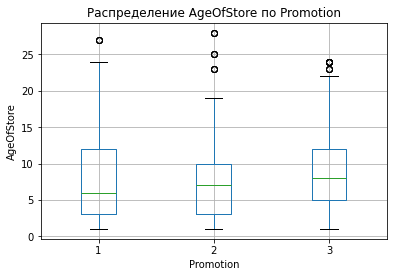

In [99]:
plt.figure()
data.boxplot(column='AgeOfStore', by='Promotion')
plt.title('Распределение AgeOfStore по Promotion')
plt.suptitle('')
plt.ylabel('AgeOfStore')
plt.show()

<Figure size 432x288 with 0 Axes>

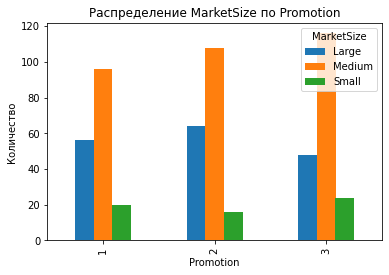

In [100]:
plt.figure()
ms_contingency.plot(kind='bar')
plt.title('Распределение MarketSize по Promotion')
plt.ylabel('Количество')
plt.show()

<Figure size 432x288 with 0 Axes>

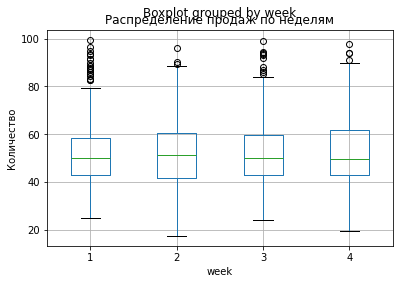

In [101]:
plt.figure()
data.boxplot(column='SalesInThousands', by='week')
plt.title('Распределение продаж по неделям')
plt.ylabel('Количество')
plt.show()

Вывод: данные распределены равномерно

## Проведение статистических тестов

Для того, чтобы выяснить, какой способ продвижения наиболее эффективен, выберем ANOVA-тест, для которого необходимы следующие условия на датасет:

- Наблюдения независимы
- Дисперсии равны
- Данные распределены нормально внутри групп

1-ый пункт проверен выше

### Тест Левена для проверки равенства дисперсии

In [102]:
groups = [data.loc[data['Promotion'] == p, 'SalesInThousands'] for p in sorted(data.Promotion.unique())]
lev_stats, lev_p = stats.levene(*groups)
print(f"Levene test для SalesInThousands: W={lev_stats:.3f}, p-value={lev_p:.3f}")
if lev_p < 0.05:
    print("Дисперсии не равны")
else:
    print("Дисперсии равны")

Levene test для SalesInThousands: W=1.270, p-value=0.282
Дисперсии равны


### Тест Шапиро-Уилка для проверки нормальности распределения

In [103]:
shapiro_results = pd.DataFrame({p: stats.shapiro(g) for p, g in zip(sorted(data.Promotion.unique()), groups)}).T
shapiro_results.columns = ['W', 'p-value']
shapiro_results

,W,p-value
1,0.915300,1.977265e-08
2,0.914510,5.457100e-09
3,0.920768,1.499466e-08


Видно, что данные во всех группах распределены не нормально, поэтому от ANOVA придётся отказаться, вместо этого применим бутстрап

### Проверка различий в трёх группах с помощью бутстрапа

In [104]:
n_bootstraps = 10000
results = []

for promo, group_df in data.groupby('Promotion', observed=True):
    sales = group_df['SalesInThousands'].values
    stats = []
    for _ in range(n_bootstraps):
        sample = np.random.choice(sales, size=len(sales), replace=True)
        stats.append(np.mean(sample))
    stats = np.array(stats)

    results.append({
        'Promotion': promo,
        'mean': stats.mean(),
        'ci_lower': np.percentile(stats, 2.5),
        'ci_upper': np.percentile(stats, 97.5)
    })

results_df = pd.DataFrame(results)
print(results_df)

   Promotion       mean   ci_lower   ci_upper
0          1  58.083969  55.670747  60.621958
1          2  47.321605  45.173273  49.553581
2          3  55.356981  53.038512  57.729972


Мы видим, что доверительные интервалы пересекаются для Promotion = 1, 3. При этом для Promotion = 2 доверительный интервал левее остальных двух, поэтому этот способ продвижения можно сразу отбросить

### Бутстрап для сравнения 1 и 3 групп

Наблюдаемая разница: 2.735
95% CI: (-0.674, 6.223)
p-value: 0.501


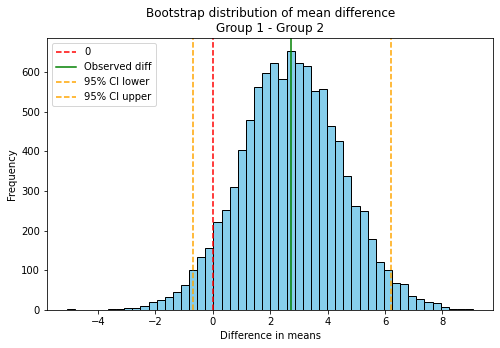

In [105]:
group_a = 1
group_b = 2
rng = np.random.default_rng(42)

x = data.loc[data['Promotion'] == 1, 'SalesInThousands'].values
y = data.loc[data['Promotion'] == 3, 'SalesInThousands'].values

obs_diff = np.mean(x) - np.mean(y)
diffs = np.array([
    rng.choice(x, size=len(x), replace=True).mean() -
    rng.choice(y, size=len(y), replace=True).mean()
    for _ in range(n_bootstraps)
])
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
p_val = np.mean(np.abs(diffs) >= np.abs(obs_diff))

print(f"Наблюдаемая разница: {obs_diff:.3f}")
print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f})")
print(f"p-value: {p_val:.3f}")

plt.figure(figsize=(8, 5))
plt.hist(diffs, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='0')
plt.axvline(obs_diff, color='green', linestyle='-', label='Observed diff')
plt.axvline(ci_lower, color='orange', linestyle='--', label='95% CI lower')
plt.axvline(ci_upper, color='orange', linestyle='--', label='95% CI upper')
plt.title(f"Bootstrap distribution of mean difference\nGroup {group_a} - Group {group_b}")
plt.xlabel("Difference in means")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Вывод: нет статистической разницы между Promotion = 1 и Promotion = 3

Рекомендуется отказаться от способа продвижения Promotion = 2 и выбрать наименее дорогостоящий из Promotion = 1, 3

## 